In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

In [17]:
subs_wlatlon = pd.read_csv("Data\\SUB_EGAT.csv")
subs_wlatlon.reset_index(inplace=True,drop=True)
subs_wlatlon = gpd.GeoDataFrame(subs_wlatlon, geometry =gpd.points_from_xy(subs_wlatlon['LONG,N,19,11'],subs_wlatlon['LAT,N,19,11']))
subs_wlatlon = subs_wlatlon.loc[subs_wlatlon['STATUS,C,50'] == 'EXISTING']
subs_wlatlon.reset_index(inplace=True,drop=True)
subs_wlatlon.crs = {'init': 'epsg:4326'}
print(subs_wlatlon)

    STATIONID,C,4     NAME_E,C,100 SUBNAME_T,C,100  \
0              AN    AMNAT CHAROEN   สฟ.อำนาจเจริญ   
1              AP          AO PHAI      สฟ.อ่าวไผ่   
2             AT1      ANG THONG 1    สฟ.อ่างทอง 1   
3             AT2      ANG THONG 2    สฟ.อ่างทอง 2   
4             AY1      AYUTTHAYA 1     สฟ.อยุธยา 1   
..            ...              ...             ...   
246            WN         WANG NOI      สฟ.วังน้อย   
247           WNK  WATTHANA NAKHON     สฟ.วัฒนานคร   
248           YL1           YALA 1       สฟ.ยะลา 1   
249           YL2           YALA 2       สฟ.ยะลา 2   
250            YT         YASOTHON        สฟ.ยโสธร   

                                        LOCATION,C,254  LAT,N,19,11  \
0    165 หมู่ 2 ถ.ชยางกูร ต.ไก่ดำ อ.เมือง จ.อำนาจเจ...    15.808659   
1     285 หมู่ 6 ต.ทุ่งสุขลา อ.ศรีราชา จ.ชลบุรี  20230    13.126233   
2       68  หมู่ 11 ต.บ้านอิฐ อ.เมือง จ.อ่างทอง  14000    14.583561   
3            ต.ม่วงเตี้ย อ.วิเศษชัยชาญ จ.อ่างทอง 14110    14.612462

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]
xr_landuse = xr.open_dataset("Data//C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1-001.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2020-01-01')
xr_landuse = xr_landuse.drop_vars('time')

df_landuse_distancetosubs = xr_landuse['lccs_class'].to_dataframe()
df_landuse_distancetosubs.reset_index(inplace=True)
df_landuse_distancetosubs = df_landuse_distancetosubs.rename(columns= {'lccs_class' : 'SI_Solar'})
df_landuse_distancetosubs = gpd.GeoDataFrame(df_landuse_distancetosubs, geometry =gpd.points_from_xy(df_landuse_distancetosubs['lon'],df_landuse_distancetosubs['lat']))
df_landuse_distancetosubs.crs = {'init': 'epsg:4326'}

df_distancetosubs = gpd.sjoin_nearest(df_landuse_distancetosubs,subs_wlatlon,distance_col="distance",how='left')

for i in df_distancetosubs.columns:
    if i not in (['lon_left','lat_left','lon','lat','distance','geometry']):
        df_distancetosubs = df_distancetosubs.drop(columns=i)


try: 
    df_distancetosubs = df_distancetosubs.rename(columns= {'lon_left' : 'lon'})
    df_distancetosubs = df_distancetosubs.rename(columns= {'lat_left' : 'lat'})
except:
    None

df_distancetosubs.reset_index(inplace=True,drop=True)

try: 
    df_distancetosubs = df_distancetosubs.drop(columns=['geometry'])
except:
    None

print(df_distancetosubs.columns)
df_distancetosubs = df_distancetosubs.groupby(['lat', 'lon']).agg('mean')
df_distancetosubs.reset_index(inplace=True)
df_distancetosubs = df_distancetosubs.set_index(['lat', 'lon'])
print(df_distancetosubs)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect.

Index(['lat', 'lon', 'distance'], dtype='object')
                      distance
lat       lon                 
5.615278  97.345833   2.456724
          97.348611   2.455599
          97.351389   2.454476
          97.354167   2.453356
          97.356944   2.452238
...                        ...
20.462500 105.623611  2.925047
          105.626389  2.926937
          105.629167  2.928828
          105.631944  2.930720
          105.634722  2.932614

[15957810 rows x 1 columns]


In [19]:
df_distancetosubs.reset_index(inplace=True)
df_distancetosubs = gpd.GeoDataFrame(df_distancetosubs, geometry =gpd.points_from_xy(df_distancetosubs['lon'],df_distancetosubs['lat']))

df_distancetosubs['SI_DtoSubs'] = 0
df_distancetosubs['SI_DtoSubs'] = df_distancetosubs['SI_DtoSubs'].astype('float')
## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.geometry.unary_union

min = df_distancetosubs['distance'].loc[df_distancetosubs.within(boundaries)].min()
max = df_distancetosubs['distance'].loc[df_distancetosubs.within(boundaries)].max()
df_distancetosubs['distance'].loc[~df_distancetosubs.within(boundaries)] = 0


df_distancetosubs['SI_DtoSubs'] = 3* (df_distancetosubs['distance']-min)/(max-min)
maxscore = df_distancetosubs['SI_DtoSubs'].max()
df_distancetosubs['SI_DtoSubs']  = maxscore - df_distancetosubs['SI_DtoSubs'] 

df_distancetosubs['SI_BGEC'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_Biomass'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_Solar'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_Wind'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_BGWW'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_MSW'] = df_distancetosubs['SI_DtoSubs']
df_distancetosubs['SI_IEW'] = df_distancetosubs['SI_DtoSubs']

df_distancetosubs = df_distancetosubs.drop(columns='SI_DtoSubs')

xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_landuse_suitability_index= xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))

df_distancetosubs['SI_BGEC'].loc[df_landuse_suitability_index['SI_BGEC'] ==  0] = 0
df_distancetosubs['SI_Biomass'].loc[df_landuse_suitability_index['SI_Biomass'] ==  0] = 0
df_distancetosubs['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
df_distancetosubs['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0
df_distancetosubs['SI_BGWW'].loc[df_landuse_suitability_index['SI_BGWW'] ==  0] = 0
df_distancetosubs['SI_MSW'].loc[df_landuse_suitability_index['SI_MSW'] ==  0] = 0
df_distancetosubs['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0

print(df_distancetosubs)

try: 
    df_distancetosubs = df_distancetosubs.drop(columns=['distance','geometry'])
except:
    None

df_distancetosubs = df_distancetosubs.groupby(['lat', 'lon']).agg('mean')
df_distancetosubs.reset_index(inplace=True)
df_distancetosubs = df_distancetosubs.set_index(['lat', 'lon'])


xr_distancetosubs = xr.Dataset.from_dataframe(df_distancetosubs)
xr_distancetosubs.to_netcdf(path='Output\\xr_SI_Distancetosubstation.nc')
print(xr_distancetosubs)


C:\Users\basna\AppData\Local\Temp\ipykernel_20656\570266905.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_20656\570266905.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

                lat         lon  distance                    geometry  \
0          5.615278   97.345833       0.0    POINT (97.34583 5.61528)   
1          5.615278   97.348611       0.0    POINT (97.34861 5.61528)   
2          5.615278   97.351389       0.0    POINT (97.35139 5.61528)   
3          5.615278   97.354167       0.0    POINT (97.35417 5.61528)   
4          5.615278   97.356944       0.0    POINT (97.35694 5.61528)   
...             ...         ...       ...                         ...   
15957805  20.462500  105.623611       0.0  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389       0.0  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167       0.0  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944       0.0  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722       0.0  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_MSW  SI_IEW  
0             0.0         0.0       0.0      0.

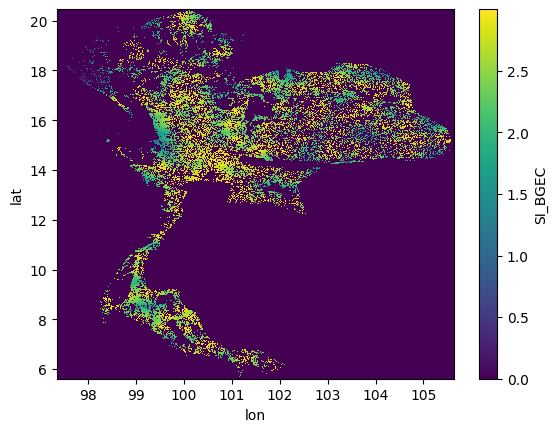

In [20]:
xr_distancetosubs['SI_BGEC'].plot()

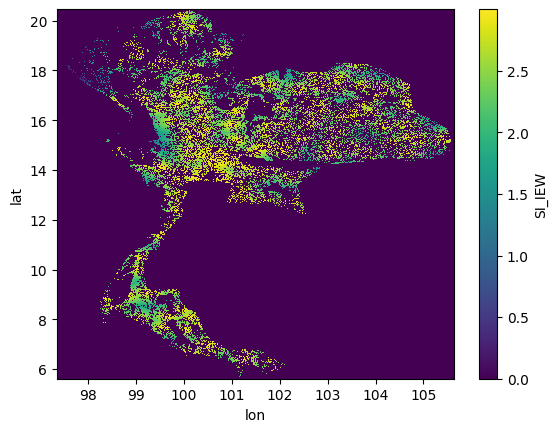

In [22]:
xr_distancetosubs['SI_IEW'].plot()